In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.show()
import numpy as np
import seaborn as sns
plt.style.use('ggplot')


In [9]:
fileloc=r'F:\Udacity\DataScience_Nd\DS_Blog_Post\Data'

boston_data_calendar=pd.read_csv(fileloc+r'\calendar.csv')
boston_data_listings=pd.read_csv(fileloc+r'\listings.csv')
boston_data_reviews=pd.read_csv(fileloc+r'\reviews.csv')


2016-09-06 2017-09-05


### Lets find out the date range of values that are available in the dataset

In [93]:

print(boston_data_calendar.date.min(),boston_data_calendar.date.max())

2016-09-06 2017-09-05


This dataset includes data that is listed for a period of one year.With that initial listing of the data lets start off with a question that we want to start off with for the dataset .

###  1.)Are there trends in prices during certain months?

Before we start answering the question,we want to find out if the dataset is clean enough for us to jump ahead and do the analysis.A small peek into the dataset is below:

In [95]:
boston_data_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


From what we find from this dataframe  it looks like column price is being read in as a object which is equivalent to a string in pandas .Date column is also being read in as a object.This is the default behaviour in pandas .So lets go ahead some code to clean this data and put this in a function to make sure that we can reuse it later in our analysis.

In [96]:

def clean_data(df,col):
    
    '''
    This function takes in a dataframe as a input ,cleans it by assigning appropriate dtypes to the columns and 
    returns a cleaned dataframe.It also drops those rows where the price column is absent.
    
    Input:
    A df with column to be cleaned in as input .This is written for cleaning the price column in the dataframes
    
    Output:
    A cleaned dataframe
    
    
    '''
    
    if col not in df.columns:
        print("col not found")
        
        return
    
    #drop na's where price is not available
    df=df.dropna(subset=['price'])
    
    #Assign price as a float column
    df.price=df.price.str.replace(r'$','',regex=False)
    
    #if teh column also contains a comma 
    if (df[col].str.contains(',')).any():
        df[col]=df[col].str.replace(r',','',regex=False)
    df[col]=df[col].astype('float')
    
    
    #Check if the dataframe has a date column .If so,convert it to the appropriate datatype
    if 'date' in df.columns:
        df.date=pd.to_datetime(df.date)
    

    return df


In [97]:
boston_data_calendar=clean_data(boston_data_calendar,'price')


F:\Anaconda\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Now with the dataframe being cleaned and ready for analysis.Lets proceed to the next steps that are necessary.As the date column has values ranging over 2 years ,to do an analysis ,its wise to join the year and month and create a seperate column within the dataframe

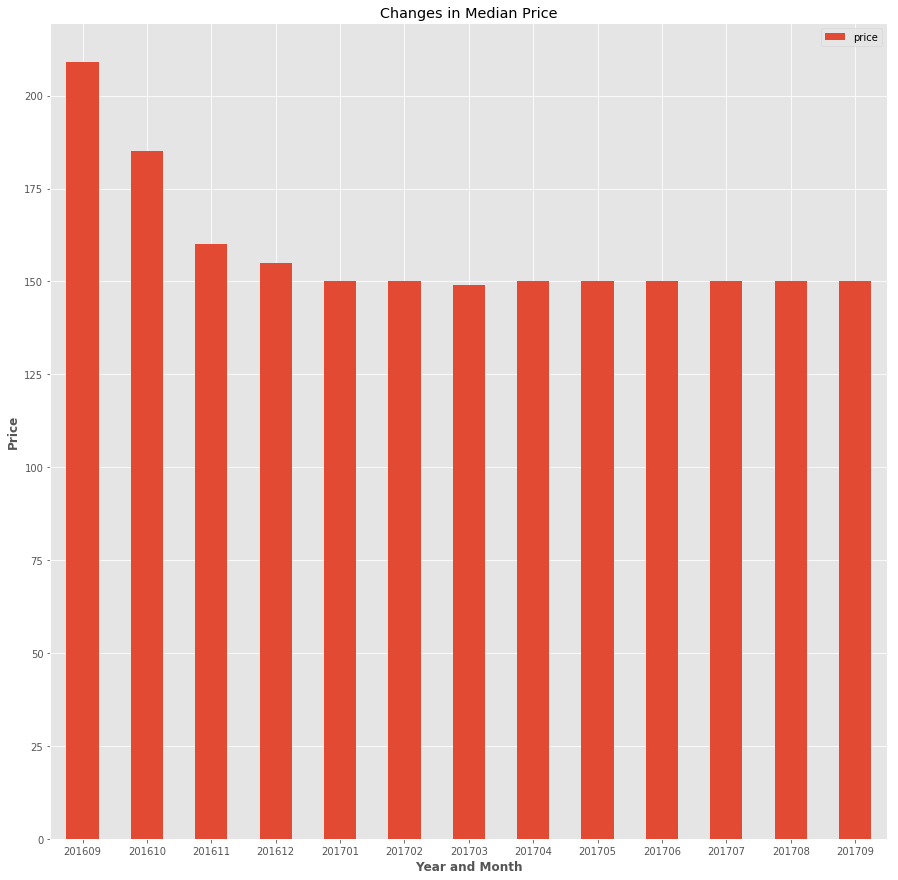

In [168]:
fig,ax2=plt.subplots()
df.groupby(['year_month']).agg({'price':'median'}).plot(kind='bar',rot=0,figsize=(15,15),ax=ax2)
ax2.set_xlabel('Year and Month',fontsize=12,fontweight='bold')
ax2.set_ylabel('Price',fontweight='bold')
ax2.set_title('Changes in Median Price')


We do see that there are trends in the data .Some months of the year have high prices and some have low prices on an average.Lets dig in deep to see whats the reason behind the difference.

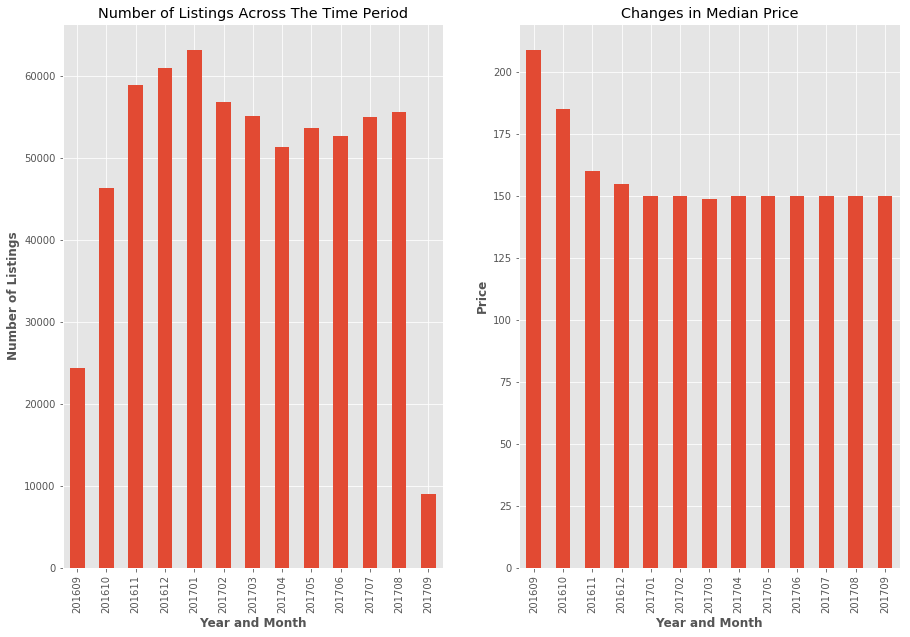

In [7]:
#Make a copy of the dataframe 
df=boston_data_calendar.copy()

#Create a new column to contain the month and year information from date column
df['year_month']=(df['date'].dt.year*100)+ (df['date'].dt.month)

#Start grouping data for analysis.Create 2 subplots to ensure that the data can be viewed side by side.

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,10))

df.groupby(['year_month']).agg({'listing_id':'count'}).plot(kind='bar',ax=ax1,legend=False)
ax1.set_xlabel('Year and Month',fontsize=12,fontweight='bold')
ax1.set_ylabel('Number of Listings',fontweight='bold')
ax1.set_title('Number of Listings Across The Time Period')


df.groupby(['year_month']).agg({'price':'median'}).plot(kind='bar',ax=ax2,legend=False)
ax2.set_xlabel('Year and Month',fontsize=12,fontweight='bold')
ax2.set_ylabel('Price',fontweight='bold')
ax2.set_title('Changes in Median Price')
plt.savefig(r'F:\Udacity\DataScience_Nd\DS_Blog_Post\Price_Comparison.jpg')

We do see that the variability is due to the number of listings.Lets see how is the price column distributed by using a boxplot. 

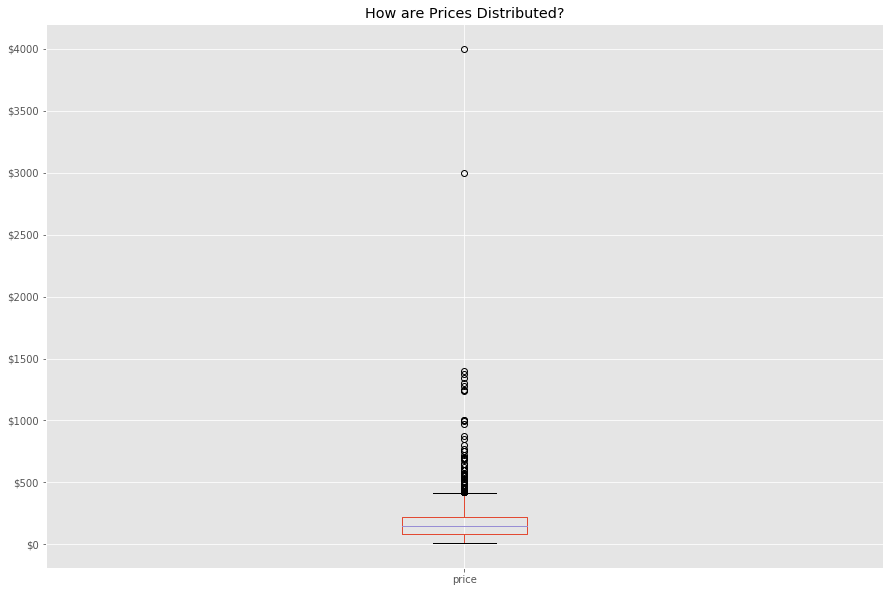

In [19]:
#boston_data_listings=clean_data(boston_data_listings,'price')

fig,ax1=plt.subplots(figsize=(15,10))
boston_data_listings.price.plot(kind='box')
ax1.set_title('How are Prices Distributed?')


arr1=ax1.get_yticks()

arr1=['$'+str(int(round(x,0))) for x in arr1]

ax1.set_yticklabels(list(arr1));

plt.savefig(r'F:\Udacity\DataScience_Nd\DS_Blog_Post\Price_Distribution.jpg')

As customer reviews are a great way to popularize homes ,lets base our analysis on customer reviews .Lets start off with analyzing top 10 percentile of high review and low review homes and find out reasons as to why they are so.

In [20]:
#define percentiles to find out the top 10 percentile of high reviews and bottom 10 percentile of low reviews
top_percentile=0.9
bottom_percentile=0.10


#As the reviews are subjective lets go by the high review ratings of number_of_listings_recieved(75 percentile of number of reviews)
high_reviews=boston_data_listings[(boston_data_listings.number_of_reviews>=21) & \
                                  (boston_data_listings.review_scores_rating>= boston_data_listings.review_scores_rating.quantile(top_percentile))]
low_reviews=boston_data_listings[(boston_data_listings.number_of_reviews>=21) & \
                                  (boston_data_listings.review_scores_rating<= boston_data_listings.review_scores_rating.quantile(bottom_percentile))]

How many rows did we find to be in the top 10 and the bottom 10 percentile?

In [22]:
print(high_reviews.shape,low_reviews.shape)

(14, 95) (33, 95)


### 2.)How are prices differenct across these 2 dataframes?

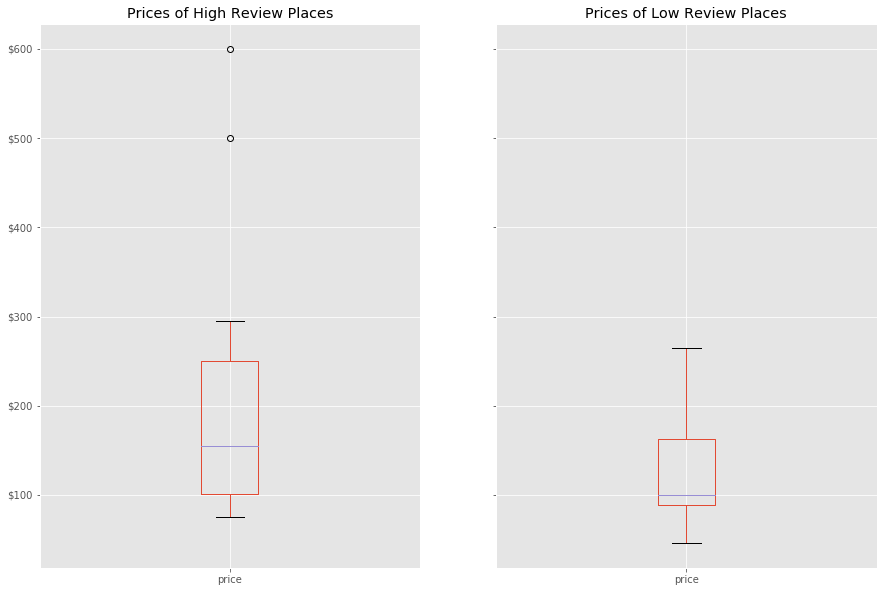

In [23]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,10),sharey=True)

high_reviews['price'].plot(kind='box',ax=ax1)
ax1.set_title('Prices of High Review Places')
arr1=ax1.get_yticks()

arr1=['$'+str(int(round(x,0))) for x in arr1]

ax1.set_yticklabels(list(arr1))


low_reviews['price'].plot(kind='box',ax=ax2)
ax2.set_title('Prices of Low Review Places')

plt.savefig(r'F:\Udacity\DataScience_Nd\DS_Blog_Post\Review_Prices.jpg')


As the prices for high reviewed homes are high,lets find out if it has got to do with the area being large ?

### 3.) Room Types 

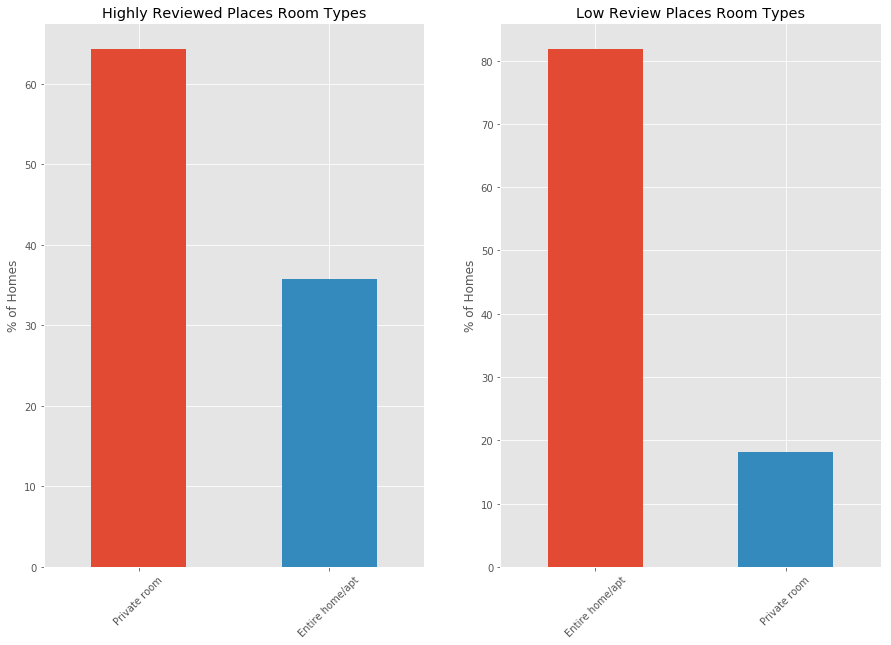

In [45]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,10))
((high_reviews.room_type.value_counts(normalize=True))*100).plot(kind='bar',rot=45,ax=ax1)
ax1.set_ylabel('% of Homes')
ax1.set_title('Highly Reviewed Places Room Types')


((low_reviews.room_type.value_counts(normalize=True))*100).plot(kind='bar',rot=45,ax=ax2)
ax2.set_ylabel('% of Homes')
ax2.set_title('Low Review Places Room Types');

plt.savefig(r'F:\Udacity\DataScience_Nd\DS_Blog_Post\RoomTypes.jpg')


In [531]:
#The above information indicates that entire home/apt room types are the most common.

#But high review listings are mostly individual rooms which makes it easier for it to be kept clean.This increases satisfaction 
#amongst the customers.

#For low review listings most of them are entire home/apt where extra care is needed to maintain the whole home.This might be the 
#reason why customers feel these low reviewed listings to be low on cleanliness.




KeyError: 'listing_id'

### 4.) Reviews by Neighborhoods

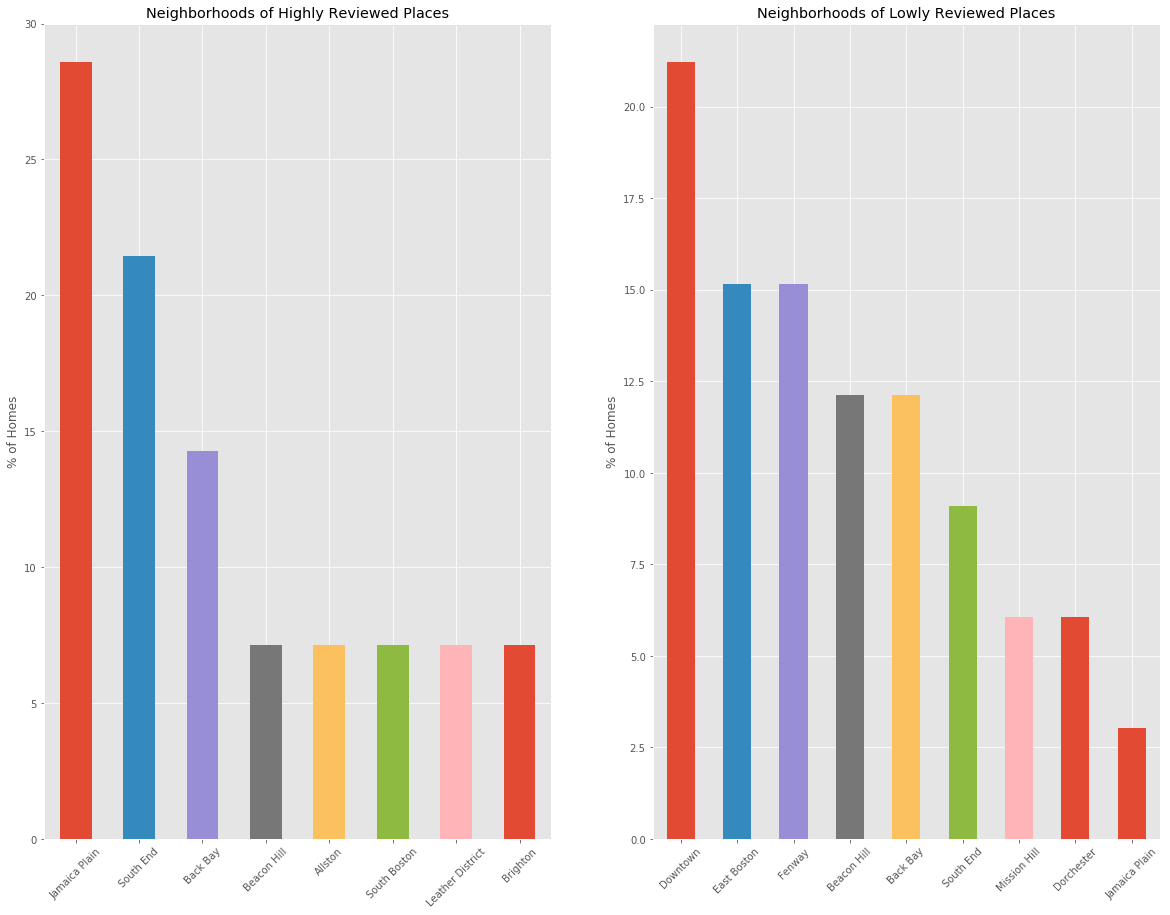

In [62]:
fig,(ax2,ax3)=plt.subplots(ncols=2,figsize=(20,15))
#(boston_data_listings.neighbourhood_cleansed.value_counts(normalize=True)*100).plot(kind='bar',ax=ax1)

(high_reviews.neighbourhood_cleansed.value_counts(normalize=True)*100).plot(kind='bar',ax=ax2,rot=45)
ax2.set_ylabel('% of Homes')
ax2.set_title('Neighborhoods of Highly Reviewed Places')

(low_reviews.neighbourhood_cleansed.value_counts(normalize=True)*100).plot(kind='bar',ax=ax3,rot=45)
ax3.set_ylabel('% of Homes')
ax3.set_title('Neighborhoods of Lowly Reviewed Places');

plt.savefig(r'F:\Udacity\DataScience_Nd\DS_Blog_Post\Neighborhoods.jpg')



### 5.)Sectional Breakdown

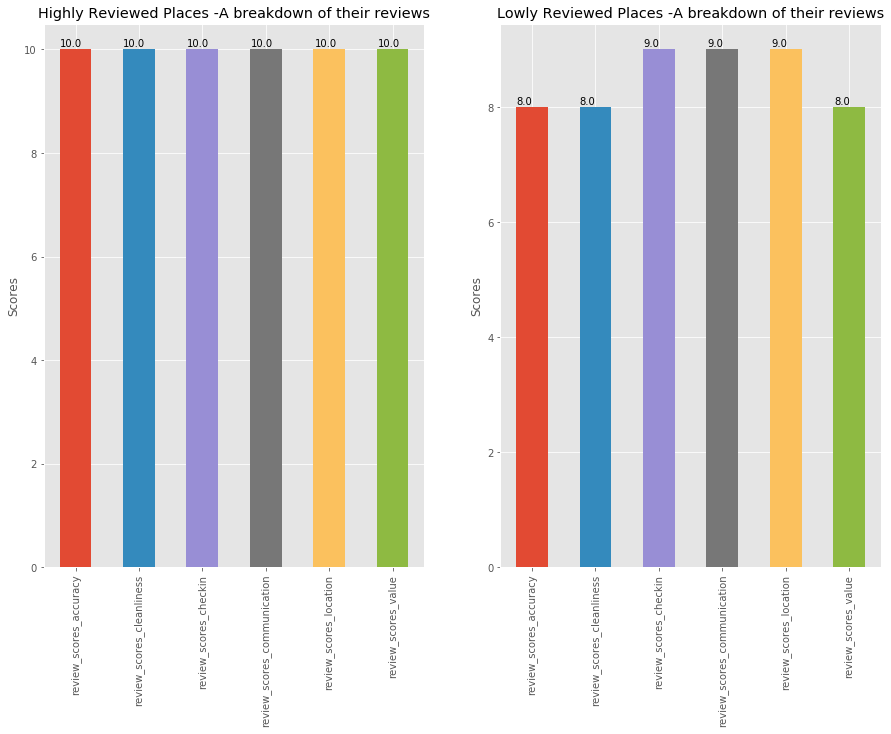

In [83]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,10))


#.plot(kind='bar',ax=ax1)
  

high_reviews[[x for x in boston_data_listings.columns if (x.startswith('review_scores_') & (x!='review_scores_rating'))]].median().plot(kind='bar',ax=ax1)
#.plot(kind='bar',ax=ax2)
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax1.set_ylabel('Scores')
ax1.set_title('Highly Reviewed Places -A breakdown of their reviews')    
    
    
low_reviews[[x for x in boston_data_listings.columns if (x.startswith('review_scores_') & (x!='review_scores_rating'))]].median().plot(kind='bar',ax=ax2)
for p in ax2.patches:
    ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
ax2.set_ylabel('Scores')
ax2.set_title('Lowly Reviewed Places -A breakdown of their reviews')    ;
plt.savefig(r'F:\Udacity\DataScience_Nd\DS_Blog_Post\ReviewBreakdown.jpg')